In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition
from openpathsampling.analysis.tis_analysis import sampleset_sample_generator

storage = paths.storage.Storage("toy_retis.nc", mode="r")

In [16]:
retis = storage.transitions.load(0)

In [17]:
retis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.025, 'bin_range' : (-0.35, 0.35) }

In [18]:
%%time
retis.all_statistics(storage=storage, weights=None, force=True)

CPU times: user 932 ms, sys: 171 ms, total: 1.1 s
Wall time: 1.04 s


In [19]:
retis.histograms.keys()

['max_lambda', 'pathlength']

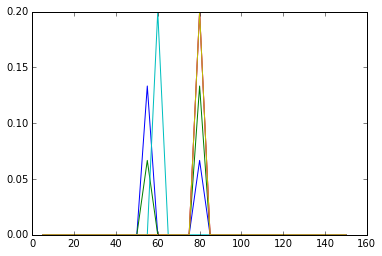

In [20]:
for ens in retis.ensembles:
    myhist = retis.histograms['pathlength'][ens]
    plt.plot(myhist.plot_bins(), myhist.normalized())

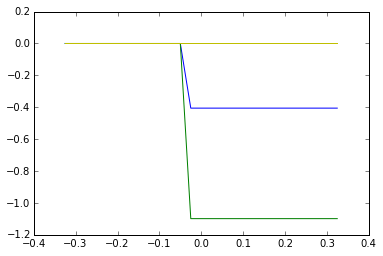

In [21]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), 
             np.log(myhist.reverse_cumulative())
            )

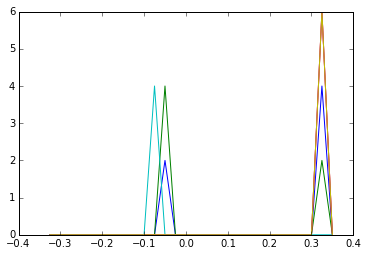

In [22]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), myhist())

In [23]:
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(storage.engines.load(0).pes)

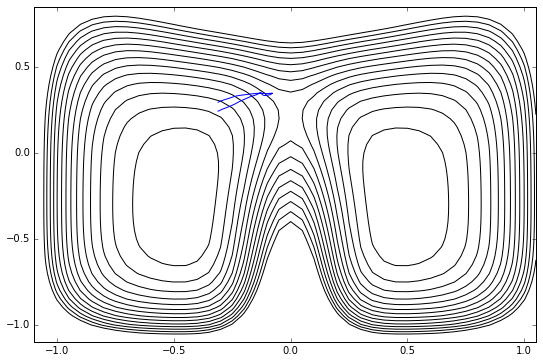

In [24]:
ens0_traj = [s.trajectory for s in storage.samples if s.ensemble == retis.ensembles[3]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,5)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

In [25]:
from openpathsampling.analysis.histogram import histograms_to_pandas_dataframe
df = histograms_to_pandas_dataframe(retis.histograms['max_lambda'].values(), fcn="reverse_cumulative").sort(axis=1)
df

,max_lambda A->B I'face 0,max_lambda A->B I'face 1,max_lambda A->B I'face 2,max_lambda A->B I'face 3,max_lambda A->B I'face 4,max_lambda A->B I'face 5
-3.250000e-01,1.000000,1.000000,1,1,1,1
-3.000000e-01,1.000000,1.000000,1,1,1,1
-2.750000e-01,1.000000,1.000000,1,1,1,1
-2.500000e-01,1.000000,1.000000,1,1,1,1
-2.250000e-01,1.000000,1.000000,1,1,1,1
-2.000000e-01,1.000000,1.000000,1,1,1,1
-1.750000e-01,1.000000,1.000000,1,1,1,1
-1.500000e-01,1.000000,1.000000,1,1,1,1
-1.250000e-01,1.000000,1.000000,1,1,1,1
-1.000000e-01,1.000000,1.000000,1,1,1,1


In [26]:
wham_hist = retis.total_crossing_probability()

ValueError: math domain error

In [27]:
# TODO: conveniences to make this prettier: perhaps actually make wham_hist into a histogram object
wham_hist_list = [ (k, wham_hist[k]) for k in sorted(wham_hist.keys()) ]
plt.plot(list(zip(*wham_hist_list)[0]), list(zip(*wham_hist_list)[1]))

NameError: name 'wham_hist' is not defined

In [28]:
plt.plot(list(zip(*wham_hist_list)[0]), np.log(list(zip(*wham_hist_list)[1])))

NameError: name 'wham_hist_list' is not defined